This code compares the observed EB power spectrum with the predicted signal from miscalibration angles or cosmic birefringence after recombination ($\alpha+\beta$).

We also include a sampler that shows how to use the observed EB power spectrum to measure $\alpha+\beta$.

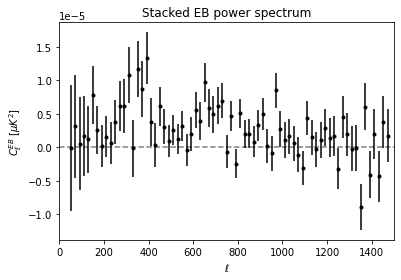

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import camb
import emcee
import corner

# Load the observed EB power spectrum
c_l_EB_o_mean_std = np.load('HFI_f_sky_092_EB_o.npy')
# c_l_EB_o_mean_std[:, 0] gives the central values for the binned observed stacked EB power spectrum
# c_l_EB_o_mean_std[:, 1] gives the corresponding error bars

# EB is binned starting at ell_min = 51, ell_max = 1490 and delta ell = 20
# For more details see the article.
ell_min = 51
ell_max = 1490
delta_ell = 20
ell = np.arange(ell_min, ell_max+1, delta_ell)
n_bins = len(ell)

# Plot the observed EB power spectrum
plt.figure()
plt.errorbar(ell, c_l_EB_o_mean_std[:, 0], yerr=c_l_EB_o_mean_std[:, 1], fmt='.', color='black')

plt.axhline(0, linestyle='--', color='black', alpha=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{EB}_{\ell}$ [$\mu K^2$]')
plt.xlim([0, 1500])
plt.title('Stacked EB power spectrum')
plt.show()


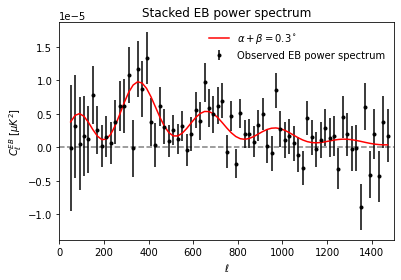

In [2]:
# Get the LCDM spectra from CAMB!
cp = camb.set_params(tau=0.0544, ns=0.9649, H0=67.36, ombh2=0.02237, omch2=0.12, As=2.1e-09, lmax=ell_max)
camb_results = camb.get_results(cp)
all_cls_th = camb_results.get_cmb_power_spectra(lmax=ell_max, raw_cl=True, CMB_unit='muK')['total']

c_l_th_EE_minus_BB = np.zeros((ell_max+1))
c_l_th_EE_minus_BB = all_cls_th[:, 1] - all_cls_th[:, 2] # EE minus BB power spectrum

# Now we bin the theoretical C^EE_ell - C^BB_ell
c_l_th_EE_minus_BB_binned = np.zeros(n_bins)
for ell_b in range(n_bins):
  c_l_th_EE_minus_BB_bin_cur = 0
  for ell_0 in range(0, delta_ell):
    ell_cur = ell_min + delta_ell * ell_b + ell_0
    c_l_th_EE_minus_BB_bin_cur += c_l_th_EE_minus_BB[ell_cur]

  c_l_th_EE_minus_BB_binned[ell_b] = c_l_th_EE_minus_BB_bin_cur / delta_ell


# Now we plot the LCDM EE-BB power spectrum rotated by 0.3 deg vs the observed EB power spectrum
plt.figure()

plt.errorbar(ell, c_l_EB_o_mean_std[:, 0], yerr=c_l_EB_o_mean_std[:, 1], fmt='.', color='black', label='Observed EB power spectrum')
plt.plot(ell, np.sin(4 * 0.3 * np.pi/180)/2 * c_l_th_EE_minus_BB_binned, label = r'$\alpha+\beta = 0.3^\circ$', color='red')

plt.axhline(0, linestyle='--', color='black', alpha=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{EB}_{\ell}$ [$\mu K^2$]')
plt.xlim([0, 1500])
plt.title('Stacked EB power spectrum')
plt.legend(frameon=False)
plt.show()

100%|██████████| 3000/3000 [00:01<00:00, 2057.04it/s]


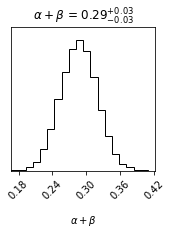

In [3]:
# Now we sample alpha+beta!

# Use Numba to speed it up! This is the log-likelihood
@nb.njit()
def log_prob(alpha_p_beta):
  v_b = c_l_EB_o_mean_std[:, 0] - np.sin(alpha_p_beta * 4 * np.pi/180)/2 * c_l_th_EE_minus_BB_binned

  var_EB = c_l_EB_o_mean_std[:, 1]**2
  return -0.5 * np.sum(v_b**2 / var_EB)

# 32 chains
nwalkers = 32
# 1 parameter (alpha+beta)
ndim = 1
p0 = np.random.rand(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

# Run for 200 samples as burnin
state = sampler.run_mcmc(p0, 200, progress=True)
sampler.reset()

# Sample for real by using last chain as start
sampler.run_mcmc(state, 3000, progress=True)
samples = sampler.get_chain(flat=True)

# Plot the posterior distribution
corner.corner(samples, labels=[r'$\alpha+\beta$'], show_titles=True, fontsize=12, color='black', title_fmt='.2f')#, truths=[0, 0, 0])
plt.show()

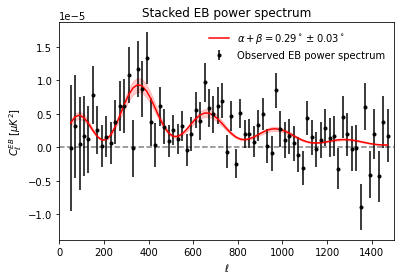

In [4]:
# Now we plot the observed EB power spectrum vs the measured alpha+beta.
# This recreates the red line in Fig 1 of Eskilt et al 2023.
alpha_beta_mean = np.mean(samples)
alpha_beta_std = np.std(samples)

plt.figure()

plt.errorbar(ell, c_l_EB_o_mean_std[:, 0], yerr=c_l_EB_o_mean_std[:, 1], fmt='.', color='black', label='Observed EB power spectrum')
plt.plot(ell, np.sin(4 * alpha_beta_mean * np.pi/180)/2 * c_l_th_EE_minus_BB_binned, label = r'$\alpha+\beta = {:.2f}^\circ \pm {:.2f}^\circ$'.format(alpha_beta_mean, alpha_beta_std), color='red')
plt.fill_between(ell, np.sin(4 * (alpha_beta_mean - alpha_beta_std) * np.pi/180) / 2 * c_l_th_EE_minus_BB_binned, np.sin(4 * (alpha_beta_mean + alpha_beta_std) * np.pi/180) / 2 * c_l_th_EE_minus_BB_binned, color='red', alpha=0.2)

plt.axhline(0, linestyle='--', color='black', alpha=0.5)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{EB}_{\ell}$ [$\mu K^2$]')
plt.xlim([0, 1500])
plt.title('Stacked EB power spectrum')
plt.legend(frameon=False)
plt.show()